##**Term Project**
Implementation of paper 


## 1 Import Modules

In [1]:
# Import your modules here
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import pandas as pd

!git clone https://github.com/kaldi-asr/kaldi.git kaldi --origin upstream
%cd kaldi
!git pull
%cd ..
!git clone https://github.com/mravanelli/pytorch-kaldi



Cloning into 'kaldi'...
remote: Enumerating objects: 114617, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 114617 (delta 3), reused 15 (delta 1), pack-reused 114598
Receiving objects: 100% (114617/114617), 121.76 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (88432/88432), done.
/content/kaldi
Already up to date.
/content
Cloning into 'pytorch-kaldi'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 805 (delta 0), reused 2 (delta 0), pack-reused 802
Receiving objects: 100% (805/805), 581.76 KiB | 20.06 MiB/s, done.
Resolving deltas: 100% (480/480), done.


In [9]:
%cd /content/kaldi/
!chmod 777 INSTALL
%cd tools
!sudo apt-get install automake autoconf sox libtool subversion
!CXX=g++-4.8 extras/check_dependencies.sh
!make -j 4
!chmod 777 INSTALL
!./INSTALL
%cd ../src
!./configure --use-cuda --cudatk-dir=/usr/local/cuda/ --cuda-arch=-arch=sm_70
!make -j 8
!chmod 777 INSTALL
!./INSTALL
%cd ../..
!pip install -r /content/pytorch-kaldi/requirements.txt

/content/kaldi
/content/kaldi/tools
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  autotools-dev file libapr1 libaprutil1 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libserf-1-1 libsigsegv2
  libsox-fmt-alsa libsox-fmt-base libsox3 libsvn1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext libsox-fmt-all
  libtool-doc gcj-jdk m4-doc db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  autoconf automake autotools-dev file libapr1 libaprutil1 libmagic-mgc
  libmagic1 libopencore-amrnb0 libopencore-amrwb0 libserf-1-1 libsigsegv2
  libsox-fmt-alsa libsox-fmt-base libsox3 libsvn1 libtool m4 sox subversion
0 upgraded, 20 newly installed, 0 to remove and 49 not upgrad

In [5]:
%cd kaldi/egs/librispeech/s5
!./run.sh
!./local/nnet2/run_5a_clean_100.sh


/content/kaldi/egs/librispeech/s5
local/download_and_untar.sh: no such directory /export/a15/vpanayotov/data
./local/nnet2/run_5a_clean_100.sh: line 16: cuda-compiled: command not found
This script is intended to be used with GPUs but you have not compiled Kaldi with CUDA 
If you want to use GPUs (and have them), go to src/, and configure and make on a machine
where "nvcc" is installed.


## 2 Dataset
Librispeech and timit dataset by using Kaldi framework



In [ ]:
# Write your code here
# If you like, you can create subsections here and split your code into 
# meaningfully separate parts, e.g. "Loading the dataset", "Cleaning the dataset",
# "Splitting the dataset"..

print("Loading the dataset")
!wget -nc https://www.openslr.org/resources/12/train-clean-100.tar.gz


## 3 SNN Definition

Implement our own traditional SNN "cell" using PyTorch. 



In [ ]:
import torch
import math

class SNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, alpha, beta, bits):
        """
          input_size: the size of the input at a time step.
          hidden_size: the number of neurons in the hidden state.
        """
        super().__init__()
        ## @TODO: Create parameters in LSTM and initialize them
        self.input_size=input_size
        self.hidden_size=hidden_size
        np.random.seed(501) 
        self.W = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)*np.random.rand(input_size, hidden_size)))) ##Glorot(Xavier) initializer
        self.alpha = alpha
        self.beta = beta
        self.bits = bits

    def forward(self, X):
        """
          X: An input that has L time steps and for each time step, it has 
          input_size many elements. Has shape (B, L, input_size) with B being 
          the batch size.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps. 
          Both have shape (B, L, hidden_size).
        """
        ## @TODO: Process X over L timesteps and return the output
        (B, L, input_size) = X.shape

        I = torch.zeros((B, L, self.hidden_size)).double()
        V = torch.zeros((B, L, self.hidden_size)).double()
        Y = torch.zeros((B, L, self.hidden_size)).double()
        sig = torch.nn.Sigmoid()

        threshold=0
        b=0

        for t in range(L):

          x_sample = torch.reshape(X[: ,t, :].clone(),(B,input_size))
          I_prev = torch.reshape(I[: ,t-1, :].clone(),(B,self.hidden_size))
          V_prev = torch.reshape(V[: ,t-1, :].clone(),(B,self.hidden_size))
          Y_prev = torch.reshape(Y[: ,t-1, :].clone(),(B,self.hidden_size))

          k=2/(t+1)
          b=torch.max(torch.max(V_prev))*k + b*(1-t)
          threshold = b/(2**self.bits)


          temp =self.beta*I_prev + torch.tensordot(self.W,x_sample)
          I[: ,t, :] = temp
          temp = self.alpha*V_prev + temp - self.threshold*Y_prev
          V[: ,t, :] = temp 
          mask = temp>threshold
          Y[: ,t, :] = torch.floor(mask.long()*temp*2**self.bits/b)
                  
        return Y





SNN with improved dynamics v1

In [ ]:
import torch

class SNNv1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, alpha, bits):
        """
          input_size: the size of the input at a time step.
          hidden_size: the number of neurons in the hidden state.
        """
        super().__init__()
        ## @TODO: Create parameters in LSTM and initialize them
        self.input_size=input_size
        self.hidden_size=hidden_size
        np.random.seed(501) 
        self.Wfi = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)*np.random.randn(input_size, hidden_size))))
        self.Wci = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)* np.random.randn(input_size, hidden_size))))
        self.alpha = alpha
        self.bits = bits


    def forward(self, X):
        """
          X: An input that has L time steps and for each time step, it has 
          input_size many elements. Has shape (B, L, input_size) with B being 
          the batch size.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps. 
          Both have shape (B, L, hidden_size).
        """
        ## @TODO: Process X over L timesteps and return the output
        (B, L, input_size) = X.shape

        I = torch.zeros((B, L, self.hidden_size)).double()
        V = torch.zeros((B, L, self.hidden_size)).double()
        Y = torch.zeros((B, L, self.hidden_size)).double()
        F = torch.zeros((B, L, self.hidden_size)).double()
        C = torch.zeros((B, L, self.hidden_size)).double()

        sig = torch.nn.Sigmoid()
        relu = torch.nn.ReLU()

        threshold=0
        b=0

        for t in range(L):
          x_sample = torch.reshape(X[: ,t, :].clone(),(B,input_size))
          I_prev = torch.reshape(I[: ,t-1, :].clone(),(B,self.hidden_size))
          V_prev = torch.reshape(V[: ,t-1, :].clone(),(B,self.hidden_size))
          Y_prev = torch.reshape(Y[: ,t-1, :].clone(),(B,self.hidden_size))

          k=2/(t+1)
          b=torch.max(torch.max(V_prev))*k+b*(1-t)
          threshold = b/(2**self.bits)

          F[:, t, :] = sig(torch.tensordot(self.Wfi,x_sample))
          C[:, t, :] = relu(torch.tensordot(self.Wci,x_sample))
          temp = torch.reshape(F[: ,t, :].clone(),(B,self.hidden_size))*I_prev + (1-torch.reshape(F[: ,t, :].clone(),(B,self.hidden_size)))*torch.reshape(C[: ,t, :].clone(),(B,self.hidden_size))
          I[: ,t, :] = temp
          temp = self.alpha*V_prev + temp - threshold*Y_prev
          V[: ,t, :] = temp 
          mask = temp>threshold
          Y[: ,t, :] = torch.floor(mask.long()*temp*2**self.bits/b)
                  
        return Y





SNN with improved dynamics v2

In [ ]:
import torch

class SNNv2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, alpha, bits):
        """
          input_size: the size of the input at a time step.
          hidden_size: the number of neurons in the hidden state.
        """
        super().__init__()
        ## @TODO: Create parameters in LSTM and initialize them
        self.input_size=input_size
        self.hidden_size=hidden_size
        np.random.seed(501) 
        self.Wfi = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)* np.random.randn(input_size, hidden_size))))
        self.Wci = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)* np.random.randn(input_size, hidden_size))))
        
        self.Wfr = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)* np.random.randn(hidden_size, hidden_size))))
        self.Wcr = torch.nn.parameter.Parameter(torch.from_numpy((-math.sqrt(1/hidden_size)+2*math.sqrt(1/hidden_size)*np.random.randn(hidden_size, hidden_size))))

        self.alpha = alpha
        self.bits = bits


    def forward(self, X):
        """
          X: An input that has L time steps and for each time step, it has 
          input_size many elements. Has shape (B, L, input_size) with B being 
          the batch size.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps. 
          Both have shape (B, L, hidden_size).
        """
        ## @TODO: Process X over L timesteps and return the output
        (B, L, input_size) = X.shape

        I = torch.zeros((B, L, self.hidden_size)).double()
        V = torch.zeros((B, L, self.hidden_size)).double()
        Y = torch.zeros((B, L, self.hidden_size)).double()
        F = torch.zeros((B, L, self.hidden_size)).double()
        C = torch.zeros((B, L, self.hidden_size)).double()

        sig = torch.nn.Sigmoid()
        relu = torch.nn.ReLU()
        
        threshold=0
        b=0

        for t in range(L):
          x_sample = torch.reshape(X[: ,t, :].clone(),(B,input_size))
          I_prev = torch.reshape(I[: ,t-1, :].clone(),(B,self.hidden_size))
          V_prev = torch.reshape(V[: ,t-1, :].clone(),(B,self.hidden_size))
          Y_prev = torch.reshape(Y[: ,t-1, :].clone(),(B,self.hidden_size))

          k=2/(t+1)
          b=torch.max(torch.max(V_prev))*k+b*(1-t)
          threshold = b/(2**self.bits)

          F[:, t, :] = sig(torch.tensordot(self.Wfi,x_sample) + torch.tensordot(self.Wfr,Y_prev))
          C[:, t, :] = relu(torch.tensordot(self.Wci,x_sample) + torch.tensordot(self.Wcr,Y_prev))
          temp = torch.reshape(F[: ,t, :].clone(),(B,self.hidden_size))*I_prev + (1-torch.reshape(F[: ,t, :].clone(),(B,self.hidden_size)))*torch.reshape(C[: ,t, :].clone(),(B,self.hidden_size))
          I[: ,t, :] = temp
          temp = self.alpha*V_prev + temp - self.threshold*Y_prev
          V[: ,t, :] = temp 
          mask = temp>threshold
          Y[: ,t, :] = torch.floor(mask.long()*temp*2**self.bits/b)
                  
        return Y





## 4 Your Sequence Model 


In [ ]:
class SpeechRecognitionWithLSTM(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        np.random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, 2, dropout=0.1)
        self.fc = torch.nn.Linear(hidden_dim,1,bias=True)
        self.double()
    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        y = self.lstm(X)
        prediction = self.fc(y[:,-1,:])

        return prediction

In [ ]:
class SpeechRecognitionWithGRU(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        np.random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.gru = torch.nn.GRU(input_dim, hidden_dim, 2, dropout=0.1)
        self.fc = torch.nn.Linear(hidden_dim,1,bias=True)
        self.double()
    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        y = self.gru(X)
        prediction = self.fc(y[:,-1,:])

        return prediction

In [ ]:
class SpeechRecognitionWithSNN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, alpha, beta, bits):
        super().__init__()
        
        np.random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.dropout1 = torch.nn.Dropout(p=0.1)
        self.dropout2 = torch.nn.Dropout(p=0.1)

        self.SNN1 = SNN(input_dim, hidden_dim, alpha, beta, bits)
        self.SNN2 = SNN(hidden_dim, hidden_dim, alpha, beta, bits)
        self.fc = torch.nn.Linear(hidden_dim,1,bias=True)
        self.double()
    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        y = self.dropout1(X)
        y = self.SNN1(y)
        y = self.dropout2(y)
        y = self.SNN2(y)
        prediction = self.fc(y[:,-1,:])

        return prediction

In [ ]:
class SpeechRecognitionWithSNNv1(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, alpha, bits):
        super().__init__()
        
        np.random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.dropout1 = torch.nn.Dropout(p=0.1)
        self.dropout2 = torch.nn.Dropout(p=0.1)

        self.SNNv1_1 = SNNv1(input_dim, hidden_dim, alpha, bits)
        self.SNNv1_2 = SNNv1(hidden_dim, hidden_dim, alpha, bits)
        self.fc = torch.nn.Linear(hidden_dim,1,bias=True)
        self.double()
    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        y = self.dropout1(X)
        y = self.SNNv1_1(y)
        y = self.dropout2(y)
        y = self.SNNv1_2(y)
        prediction = self.fc(y[:,-1,:])

        return prediction

In [ ]:
class SpeechRecognitionWithSNNv2(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, alpha, bits):
        super().__init__()
        
        np.random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.dropout1 = torch.nn.Dropout(p=0.1)
        self.dropout2 = torch.nn.Dropout(p=0.1)

        self.SNNv2_1 = SNNv2(input_dim, hidden_dim, alpha, bits)
        self.SNNv2_2 = SNNv2(hidden_dim, hidden_dim, alpha, bits)
        self.fc = torch.nn.Linear(hidden_dim,1,bias=True)
        self.double()
    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        y = self.dropout1(X)
        y = self.SNNv2_1(y)
        y = self.dropout2(y)
        y = self.SNNv2_2(y)
        prediction = self.fc(y[:,-1,:])

        return prediction

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [ ]:
# Your implementation comes here


def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  for epoch in range(epochs):
    if (epoch+1)%3==0:
      for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/2
    for i, data in enumerate(dataloader, 0):    
      # Our batch:
      inputs, labels = data
      labels=labels.reshape((labels.size(dim=0),1))
      
      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()
      
      # Obtain the scores
      outputs = model(inputs)
      
      # Calculate loss
      loss = criterion(outputs, labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [ ]:
# Your implementation comes here

import torch.optim as optim

torch.autograd.set_detect_anomaly(True)

hidden_size = 550
input_size = 1
batch_size=64
bits = 4
alpha = 0.1
beta = 0.1
epochs = 24

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                             shuffle=True)
modelLSTM = SpeechRecognitionWithLSTM(input_size, hidden_size,)
modelGRU = SpeechRecognitionWithGRU(input_size, hidden_size)
modelSNN = SpeechRecognitionWithSNN(input_size,hidden_size, alpha, beta, bits)
modelSNNv1 = SpeechRecognitionWithSNNv1(input_size, hidden_size, alpha, bits)
modelSNNv2 = SpeechRecognitionWithSNNv2(input_size, hidden_size, alpha, bits)


criterionLSTM = torch.nn.MSELoss()
optimizerLSTM = optim.Adam(modelLSTM.parameters(), lr=1e-3)

criterionGRU = torch.nn.MSELoss()
optimizerGRU = optim.Adam(modelGRU.parameters(), lr=1e-3)

criterionSNN = torch.nn.MSELoss()
optimizerSNN = optim.Adam(modelSNN.parameters(), lr=1e-3)

criterionSNNv1 = torch.nn.MSELoss()
optimizerSNNv1 = optim.Adam(modelSNNv1.parameters(), lr=1e-3)

criterionSNNv2 = torch.nn.MSELoss()
optimizerSNNv2 = optim.Adam(modelSNNv2.parameters(), lr=1e-3)




loss_historyLSTM = train(modelLSTM, criterionLSTM, optimizerLSTM, epochs, trainloader)
loss_historyGRU = train(modelGRU, criterionGRU, optimizerGRU, epochs, trainloader)
loss_historySNN = train(modelSNN, criterionSNN, optimizerSNN, epochs, trainloader)
loss_historySNNv1 = train(modelSNNv1, criterionSNNv1, optimizerSNNv1, epochs, trainloader)
loss_historySNNv2 = train(modelSNNv2, criterionSNNv2, optimizerSNNv2, epochs, trainloader)

## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

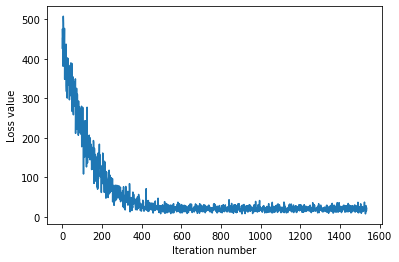

In [ ]:
# Your implementation comes here
plt.plot(loss_historyLSTM,label="LSTM")
plt.plot(loss_historyGRU,label="GRU")
plt.plot(loss_historySNN,label="SNN")
plt.plot(loss_historySNNv1,label="SNNv1")
plt.plot(loss_historySNNv2,label="SNNv2")
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

In [ ]:
import math
test = torch.utils.data.DataLoader(testset,
                                      shuffle=False)
loss=0

for i, data in enumerate(test, 0):
  test_inputs, test_labels = data

  outputs = modelLSTM(test_inputs)
  loss=loss+(outputs-test_labels)**2

print("LSTM rmse: ",math.sqrt(loss/len(test)))


test = torch.utils.data.DataLoader(testset,
                                      shuffle=False)
loss=0

for i, data in enumerate(test, 0):
  test_inputs, test_labels = data

  outputs = modelGRU(test_inputs)
  loss=loss+(outputs-test_labels)**2

print("GRU rmse: ",math.sqrt(loss/len(test)))


test = torch.utils.data.DataLoader(testset,
                                      shuffle=False)
loss=0

for i, data in enumerate(test, 0):
  test_inputs, test_labels = data

  outputs = modelSNN(test_inputs)
  loss=loss+(outputs-test_labels)**2

print("SNN rmse: ",math.sqrt(loss/len(test)))


test = torch.utils.data.DataLoader(testset,
                                      shuffle=False)
loss=0

for i, data in enumerate(test, 0):
  test_inputs, test_labels = data

  outputs = modelSNNv1(test_inputs)
  loss=loss+(outputs-test_labels)**2

print("SNNv1 rmse: ",math.sqrt(loss/len(test)))


test = torch.utils.data.DataLoader(testset,
                                      shuffle=False)
loss=0

for i, data in enumerate(test, 0):
  test_inputs, test_labels = data

  outputs = modelSNNv2(test_inputs)
  loss=loss+(outputs-test_labels)**2

print("SNNv2 rmse: ",math.sqrt(loss/len(test)))

